In [ ]:
#print torch version
import torch
print(torch.__version__)

2.5.1+cu121


In [6]:
#check torch uninstallation
import torch

In [2]:
import torchvision
from torchvision import datasets, transforms
import torch
import numpy as np
print(torch.version.cuda)


None


In [23]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


No GPU available. Training will run on CPU.


In [ ]:
# Define transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\Administrator\Desktop\EfficientNet\Dataset', transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
#print train and test dataset size
print('Train dataset size: ', len(train_dataset))
print('Test dataset size: ', len(test_dataset))

Train dataset size:  19200
Test dataset size:  4800


In [16]:
import torch.nn as nn
import torchvision.models as models

class LightingRobustCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(LightingRobustCNN, self).__init__()
        # Use a pre-trained ResNet as the backbone
        self.backbone = models.resnet18(pretrained=True)
        # Replace the final layer for 1000 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize the model
model = LightingRobustCNN(num_classes=1000)

In [17]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [18]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], Loss: 5.6719
Epoch [2/20], Loss: 1.3487
Epoch [3/20], Loss: 0.1401
Epoch [4/20], Loss: 0.0567
Epoch [5/20], Loss: 0.0952
Epoch [6/20], Loss: 0.0596
Epoch [7/20], Loss: 0.0490
Epoch [8/20], Loss: 0.0699
Epoch [9/20], Loss: 0.0302


KeyboardInterrupt: 

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].


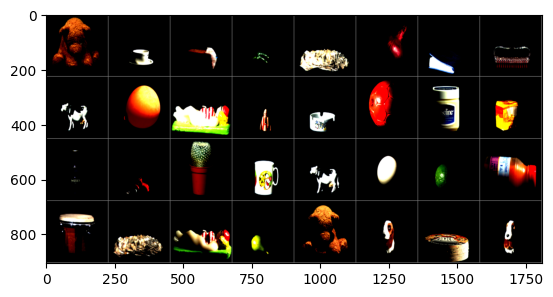

GroundTruth:  29 78 99 98
Predicted:  29 78 99 98


In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images and predictions
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(4)))